In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation
import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

sys.path.append("/home/shihab/repo/src")
from analysis_utils import convert_to_tensors, shuffle_and_split, prepare_vectors
from utils import save_parameters_to_csv

torch.manual_seed(42)
np.random.seed(41)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)



In [3]:
# times = [("17:00", "153"), ("16:55", "795"), ("16:53", "943"),
#         ("22:12", "348"), ("22:06", "744"), ("22:05", "409")]
#times = [("01:10", "45"), ("01:06", "684"), ("01:06", "988")]
times = os.listdir("../data/2b_both/")
xs, ys = [], []
# for time, rnd in times:
#     x = np.load(f"../data/archive/X_sphere_{time}_both_{rnd}.npy")
#     y = np.load(f"../data/archive/Y_sphere_{time}_both_{rnd}.npy")
for f in times:
    file = f[1:]
    x = np.load(f"../data/2b_both/X{file}")
    y = np.load(f"../data/2b_both/Y{file}")
    xs.append(x)
    ys.append(y)



X = np.concatenate(xs, axis=0)
Y = np.concatenate(ys, axis=0)

XY = np.hstack([X, Y])          # shape: (total_rows, 16)

column_names = [
    # X columns 
    "force1_x", "force1_y", "force1_z",
    "torque1_x", "torque1_y", "torque1_z",
    
    "center_x", "center_y", "center_z", "dist", "min_dist",
    "force2_x", "force2_y", "force2_z",
    "torque2_x", "torque2_y", "torque2_z",
    # Y columns
    "vel_x", "vel_y", "vel_z",
    "angvel_x", "angvel_y", "angvel_z"
]

df = pd.DataFrame(XY, columns=column_names)
df.shape, df.columns

((40000, 23),
 Index(['force1_x', 'force1_y', 'force1_z', 'torque1_x', 'torque1_y',
        'torque1_z', 'center_x', 'center_y', 'center_z', 'dist', 'min_dist',
        'force2_x', 'force2_y', 'force2_z', 'torque2_x', 'torque2_y',
        'torque2_z', 'vel_x', 'vel_y', 'vel_z', 'angvel_x', 'angvel_y',
        'angvel_z'],
       dtype='object'))

In [4]:
y.shape

(4000, 6)

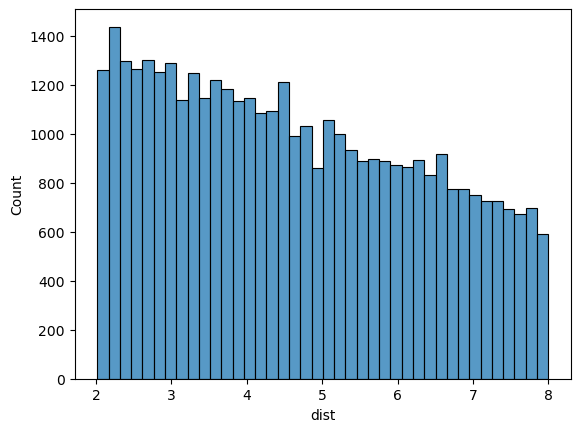

In [5]:
sns.histplot(df["dist"], bins=40);

In [6]:
df = df.rename(columns={'dist': 'r'})
print(df.shape)
#median_r = df['r'].median()
median_r = (df['r'].max()+df['r'].min())/2
print(median_r)
tmp = df['r'] - median_r #dont scale r, since we divide by it later

df['r2'] = tmp**2
df['r4'] = tmp**4

cols = df.columns.tolist()
i = cols.index('r')
new_cols = (
    cols[:i+1]
  + ['r2','r4']
  + [c for c in cols[i+1:] if c not in ('r2','r4')]
)
df = df[new_cols]

(40000, 23)
5.008307682776568


In [7]:
def prepare_vectors(df):
    force_cols = [
        'force1_x', 'force1_y', 'force1_z',
        'torque1_x', 'torque1_y', 'torque1_z',
        'force2_x', 'force2_y', 'force2_z',
        'torque2_x', 'torque2_y', 'torque2_z',
    ]
    output_cols = [
        'vel_x', 'vel_y', 'vel_z',
        'angvel_x', 'angvel_y', 'angvel_z'
    ]
    #feature_cols = [col for col in df.columns if col not in (force_cols + output_cols)]
    feature_cols = ['center_x', 'center_y', 'center_z', 'r', 'r2', 'r4', 'min_dist']
    print("Using features:", feature_cols)
    
    dist_vec   = df[feature_cols].values
    force_vec  = df[force_cols].values
    output_vec = df[output_cols].values
    return dist_vec, force_vec, output_vec

In [8]:
feat, force, vel = prepare_vectors(df)
feat, force, vel = convert_to_tensors(feat, force, vel)

tmp = list(shuffle_and_split(df, feat, force, vel, split_frac=.8))
indices = tmp.pop()

for i in range(len(tmp)):
    tmp[i] = tmp[i].to(device)

(train_dist_tensor, val_dist_tensor, 
    train_force_tensor, val_force_tensor, 
    train_velocity_tensor, val_velocity_tensor) = tmp

train_dist_tensor.shape, train_force_tensor.shape, val_dist_tensor.shape

Using features: ['center_x', 'center_y', 'center_z', 'r', 'r2', 'r4', 'min_dist']


(torch.Size([32000, 7]), torch.Size([32000, 12]), torch.Size([8000, 7]))

In [9]:
def L1(d):
    """ Computes the outer product of each 3D vector in the batch with itself. """
    # d: [batch_size, 3]
    return torch.einsum('bi,bj->bij', d, d)  # [batch_size, 3, 3]

def L2(d):
    """ Returns the matrix (I - outer(d, d)) for each vector in the batch. """
    # Identity tensor expanded to batch size
    batch_size = d.shape[0]
    I = torch.eye(3).unsqueeze(0).repeat(batch_size, 1, 1).to(device)  # [batch_size, 3, 3]
    ddT = torch.einsum('bi,bj->bij', d, d)  # [batch_size, 3, 3]
    return I - ddT

# Predefine the Levi-Civita tensor
levi_civita = torch.zeros(3, 3, 3, dtype=torch.float)
levi_civita[0, 1, 2] = 1
levi_civita[1, 2, 0] = 1
levi_civita[2, 0, 1] = 1
levi_civita[0, 2, 1] = -1
levi_civita[2, 1, 0] = -1
levi_civita[1, 0, 2] = -1

levi_civita = levi_civita.to(device)

def L3(d):
    """ Computes the cross product matrix for each 3D vector in the batch. """
    # Using einsum for batched matrix-vector multiplication:
    return torch.einsum('ijk,bk->bij', levi_civita, d)  # [batch_size, 3, 3]

def spsd_loss_func(sym_matrix, epsilon=1e-6):
    """SPSD loss representing SPSD violation
    """
    eigenvalues = torch.linalg.eigvalsh(sym_matrix)  # (batch_size, 6)
    negative_violations = torch.relu(-eigenvalues + epsilon)  # (batch_size, 6)
    loss = torch.mean(negative_violations)
    
    return loss

In [1]:
viscosity = 1.0
eigens = []

class ScNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ScNetwork, self).__init__()
        self.FtModel = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 5),
            #nn.Tanh()
        )
        self.FsModel = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 5),
            #nn.Tanh()
        )
        
    def make_mobility(self, sc, d_vec, Ms=False):
        TT = sc[:, 0].unsqueeze(1).unsqueeze(2) * L1(d_vec) + \
                sc[:, 1].unsqueeze(1).unsqueeze(2) * L2(d_vec) # TODO: d_vec or r?
        RT = sc[:, 2].unsqueeze(1).unsqueeze(2) * L3(d_vec)
        RR = sc[:, 3].unsqueeze(1).unsqueeze(2) * L1(d_vec) + \
                sc[:, 4].unsqueeze(1).unsqueeze(2) * L2(d_vec)
    
        K = torch.zeros((len(sc), 6, 6), dtype=torch.float32, device=X.device)

        # After experiments, the kernel is NOT symmetric for M_t. 
        # Top-right and bottem left should NOT be transpose of each other
        K[:, :3, :3] = TT  # Top-left block
        K[:, 3:, :3] = RT  # Bottom-left block
        K[:, :3, 3:] = RT.transpose(1, 2) if Ms else RT
        K[:, 3:, 3:] = RR  # Bottom-right block

        if Ms:
            assert torch.allclose(K, K.transpose(1, 2), atol=1e-6)
        return K


    def predict_mobility(self, X):
        d_vec, r = X[:,:3], X[:,3]
        sc_t = self.FtModel(X[:, 3:]) #exclude d_vec
        sc_s = self.FsModel(X[:, 3:]) #exclude d_vec
        
        d_vec = -d_vec/ r.unsqueeze(-1) # negative,cz dvec=target-src

        K_t = self.make_mobility(sc_t, d_vec)
        K_s = self.make_mobility(sc_s, d_vec, Ms=True)
        return K_s, K_t

    def _analytic_self_velocity(self,force, mu):
        """
        force:  (B,6) = [Fx,Fy,Fz, Tx,Ty,Tz]
        radius: (B,)   sphere radius per sample
        returns (B,6) = [Ux,Uy,Uz, Ox,Oy,Oz]
        """
        F = force[:, :3]
        T = force[:, 3:]
        inv_6pi_mu_a  = (1.0 / (6.0 * torch.pi * mu))
        inv_8pi_mu_a3 = (1.0 / (8.0 * torch.pi * mu))
        U = inv_6pi_mu_a  * F
        Omega = inv_8pi_mu_a3 * T
        return torch.cat([U, Omega], dim=1)

    def predict_velocity(self, X, force_s, force_t, return_M=False):
        M_s, M_t = self.predict_mobility(X)
        M_s, M_t = M_s/viscosity, M_t/viscosity
        v_self_t = self._analytic_self_velocity(force_s, viscosity)

        v_s = torch.bmm(M_s, force_s.unsqueeze(-1)).squeeze(-1)
        v_t = torch.bmm(M_t, force_t.unsqueeze(-1)).squeeze(-1)
        v = v_self_t + v_s + v_t

        if return_M:
            return v, (M_s, M_t)
        return v

NameError: name 'nn' is not defined

## Modelling

In [11]:
input_dim = train_dist_tensor.shape[1] - 3
print(input_dim)
batch_size = 256
epochs = 400
model = ScNetwork(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.50)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


criterion = nn.L1Loss()
#criterion = nn.MSELoss()
n_iter = train_velocity_tensor.shape[0]//batch_size
n_iter, n_iter*batch_size, len(train_dist_tensor)

4


(125, 32000, 32000)

In [12]:
def shuffle_tensors(*tensors):
    """ Shuffles multiple tensors in the same order """
    indices = torch.randperm(tensors[0].size(0),device=device)  # Generate random indices
    return tuple(tensor[indices] for tensor in tensors)
    
losses = []
data_losses, spsd_losses = [], []
for epoch in range(epochs):
    model.train()
    avg = 0
    avg_data, avg_spsd = 0, 0
    
    train_dist_tensor, train_force_tensor, train_velocity_tensor = shuffle_tensors(
        train_dist_tensor, train_force_tensor, train_velocity_tensor
    )
    for it in range(n_iter):
        optimizer.zero_grad()
        
        indices = torch.arange(it*batch_size, (it+1)*batch_size, dtype=torch.int).cuda()
        
        X = train_dist_tensor[indices]  
        force1 = train_force_tensor[indices, :6] 
        force2 = train_force_tensor[indices, 6:] 
        Y = train_velocity_tensor[indices]  
    
        batch_output, (M_s, M_t) = model.predict_velocity(X, force1, force2, return_M=True)
        M_sum = M_s + M_t

        # Compute loss
        data_loss = criterion(batch_output, Y)
        spsd_loss = 0.05 * spsd_loss_func(M_t)     #Just M_t
        spsd_loss += 0.05 * spsd_loss_func(M_sum)  # AND M_s+M_t both need to be constrained
        loss = data_loss #+ spsd_loss
        
        loss.backward()
        avg += loss.item()
        avg_data += data_loss.item()
        avg_spsd += spsd_loss.item()
        optimizer.step()
        

    scheduler.step()
    if epoch%5==0:
        print(f'Epoch {epoch}, Loss: {avg/n_iter}')
        losses.append(avg/n_iter)
        data_losses.append(avg_data/n_iter)
        spsd_losses.append(avg_spsd/n_iter)

torch.save(model.state_dict(), "combined_2body.wt")

Epoch 0, Loss: 0.18238091653585434
Epoch 5, Loss: 0.022527471773326396
Epoch 10, Loss: 0.019330605290830135
Epoch 15, Loss: 0.01644702062755823
Epoch 20, Loss: 0.01467706086486578
Epoch 25, Loss: 0.0135421928986907
Epoch 30, Loss: 0.009835057020187377
Epoch 35, Loss: 0.009547282844781875
Epoch 40, Loss: 0.008420479074120522
Epoch 45, Loss: 0.007879699379205704
Epoch 50, Loss: 0.007178122311830521
Epoch 55, Loss: 0.006624110270291567
Epoch 60, Loss: 0.009969525977969169
Epoch 65, Loss: 0.00534702636115253
Epoch 70, Loss: 0.004483572194352746
Epoch 75, Loss: 0.0038862900901585817
Epoch 80, Loss: 0.004151929516345263
Epoch 85, Loss: 0.009980397719889879
Epoch 90, Loss: 0.003524522928521037
Epoch 95, Loss: 0.004143643368035555
Epoch 100, Loss: 0.003508300280198455
Epoch 105, Loss: 0.004219441917724907
Epoch 110, Loss: 0.003178029643371701
Epoch 115, Loss: 0.0028287606937810778
Epoch 120, Loss: 0.0028940029833465814
Epoch 125, Loss: 0.0028767005186527968
Epoch 130, Loss: 0.00287071889452636

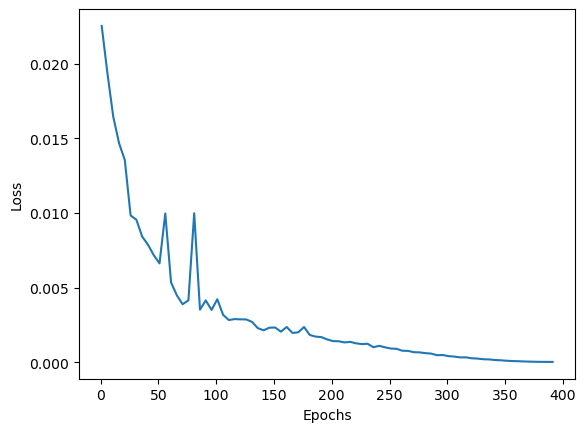

In [13]:
import matplotlib.pyplot as plt
los = losses[1:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los);
plt.ylabel("Loss")
plt.xlabel("Epochs");
#plt.savefig("loss.png");

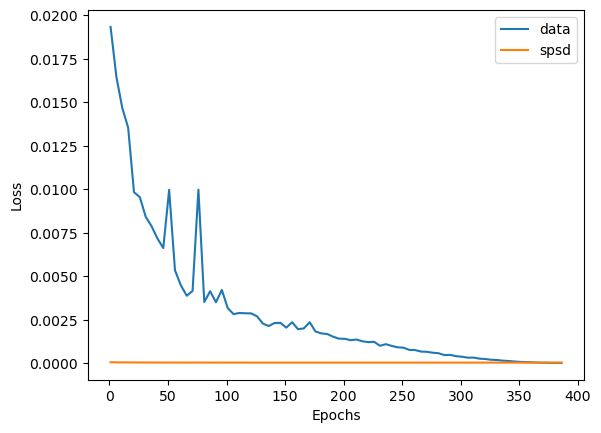

In [14]:
SKIP = 2
los = data_losses[SKIP:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los, label='data');

los = spsd_losses[SKIP:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los, label='spsd');

plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs");

In [15]:
data_losses[:5], data_losses[-5:], spsd_losses[:5], spsd_losses[-5:]

([0.18238091653585434,
  0.022527471773326396,
  0.019330605290830135,
  0.01644702062755823,
  0.01467706086486578],
 [4.427800606936216e-05,
  3.517733192711603e-05,
  2.8113566484535113e-05,
  2.563852229650365e-05,
  2.4203920387662946e-05],
 [0.0005621004252025159,
  7.413079710386228e-05,
  6.363408981906105e-05,
  5.737265307107009e-05,
  5.4424287707661276e-05],
 [4.265512971323915e-05,
  4.265491021214984e-05,
  4.2653243843233216e-05,
  4.2653751588659364e-05,
  4.265358514385298e-05])

In [16]:
model = ScNetwork(input_dim).to(device)
model.load_state_dict(torch.load("combined_2body.wt", weights_only=True))
model.eval()

eigens = []
with torch.no_grad():
    val_output, (M_s, M_t) = model.predict_velocity(
        val_dist_tensor, val_force_tensor[:, :6], val_force_tensor[:, 6:], 
        return_M=True)


N = M_s.shape[0]
device, dtype = M_s.device, M_s.dtype

# build an (N,12,12) block matrix
M_block = torch.zeros(N, 12, 12, device=device, dtype=dtype)
# top-left = M_s, top-right = M_t
M_block[:, :6, :6] = M_s
M_block[:, :6, 6:] = M_t

nonSPD = 0
for i in range(len(M_block)):
    k66 = M_t[i].detach().cpu()
    eigs = np.linalg.eigvals(k66)
    if not np.all(eigs>=- 1e-8):
        eigens.append((eigs.min(), eigs.max()))
        nonSPD += 1
        
print(f"{nonSPD=}, {len(M_block)}")

nonSPD=0, 8000


In [17]:
torch.set_printoptions(sci_mode=False, precision=6)
jj = 198
val_output[jj], val_velocity_tensor[jj]

(tensor([-0.141884,  0.855703, -0.298891,  0.207477, -0.021955, -0.544534],
        device='cuda:0'),
 tensor([-0.141582,  0.855625, -0.299198,  0.207571, -0.021922, -0.544446],
        device='cuda:0'))

In [18]:
criterion = nn.L1Loss(reduction='none') 
err = criterion(val_output, val_velocity_tensor)

rmse = err.mean(axis=0)

print("Root Mean Squared error for each of 6 output variables:\n", rmse)
print("Actual Magnitude:\n ", torch.abs(val_velocity_tensor).mean(axis=0))
print("RMSE:", err.mean())

Root Mean Squared error for each of 6 output variables:
 tensor([    0.000027,     0.000028,     0.000029,     0.000021,     0.000021,
            0.000021], device='cuda:0')
Actual Magnitude:
  tensor([0.517938, 0.518420, 0.520007, 0.373489, 0.379243, 0.368988],
       device='cuda:0')
RMSE: tensor(    0.000024, device='cuda:0')


In [19]:
#### Median Relative Absolute Error
def mean_abs_err(val_output, val_velocity_tensor, npp=False):
    # 6D vector: median % error for each vel component
    valid_mask = torch.abs(val_velocity_tensor) > 1e-6
    
    filtered_y_tensor = torch.where(valid_mask, val_velocity_tensor, torch.tensor(float('nan')))
    relative_error = torch.abs((val_output - filtered_y_tensor) / filtered_y_tensor)
    
    a = torch.nanmean(relative_error, dim=0)
    return a*100

mean_abs_err(val_output, val_velocity_tensor)

tensor([0.030187, 0.020311, 0.036579, 0.033963, 0.028706, 0.017535],
       device='cuda:0')

In [ ]:
100*rmse/torch.abs(val_velocity_tensor).mean(axis=0)

In [ ]:
idx = val_dist_tensor[:,3]<4.0
mean_abs_err(val_output[idx], val_velocity_tensor[idx])

In [ ]:
idx = val_dist_tensor[:,3]<2.6
mean_abs_err(val_output[idx], val_velocity_tensor[idx])

In [ ]:
err = torch.abs(val_output-val_velocity_tensor).mean(axis=1)

tdf = pd.DataFrame({
    'dist': val_dist_tensor[:,3].cpu().numpy(),
    'err': err.detach().cpu().numpy()
})
sns.set_style("whitegrid")
ax = sns.regplot(x='dist', y='err', data=tdf, scatter_kws={'color':'blue', 'alpha':0.15}, 
             line_kws={'color':'red'}, order=3);
ax = sns.scatterplot(x='dist', y='err', data=tdf)

In [ ]:
viscosity = 1.0


import sys
sys.path.insert(0, '/home/shihab/hignn')
from grpy_tensors import mu  #using non-torch original version

def compute_rpy_mobility(c2, return_k=False):
    global viscosity
    c = np.array([[0.0, 0.0, 0.0], list(c2)])
    radii = np.array([1.0, 1.0])  # Example radii of the particles
    
    M = mu(c, radii,blockmatrix=True)/viscosity
    res = M[:,:,0,1,:,:] #M_ji, not M_ij. (RT,TR components vary)
    K = np.zeros((6,6))
    K[:3,:3] = res[0,0]
    K[:3,3:] = res[0,1]
    K[3:,:3] = res[1,0]
    K[3:,3:] = res[1,1]

    #K = M
    return K

len_val = len(val_dist_tensor)
val_dist_arr = val_dist_tensor.cpu().numpy()
val_force_arr = val_force_tensor.cpu().numpy()
val_velocity_arr = val_velocity_tensor.cpu().numpy()
rpy_vels = np.zeros((len_val,6))
for i in range(len_val):
    x,f = val_dist_arr[i], val_force_arr[i]
    #f = np.concatenate((np.zeros_like(f), f))
    yp = compute_rpy_mobility(x[:3]) @ f[6:]
    rpy_vels[i] = yp[:6]

rpy_vels_tensor = torch.Tensor(rpy_vels).cuda()
mean_abs_err(rpy_vels_tensor, val_velocity_tensor)